# Collection person locations within frame and building a csv dataset

### Notebook 3 

In this notebook I will take the progress in using the model to identify pedestrians within frame and build a datat set of pedestrian location within a single frame.

By logging the coordinates within the following frame I'll attempt to link that coordinates that have moved very slightly will likely be from the pedestrian in the previous frame.

From this I will build a csv data set to use for future location predicition

In [1]:
import os
import sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import cv2
import json
import re

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print("Root Directory: ", ROOT_DIR)
sys.path.append(ROOT_DIR)

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from scripts import coco
from scripts import list_file_info as lfi
from scripts import video_to_frames as vtf
from scripts.centroid_tracker import CentroidTracker
from scripts.trackable_object import TrackableObject

Root Directory:  /home/sam/Documents/GitHub/honoursProject/PedestrianDetectionSGall


In [2]:
data_root = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/"

file_list = os.listdir(path = data_root) 
max = len(file_list) 

if max == 0:
    print("No video folders in directory")
else:
    print("please select video from 1 to " + str(max))

please select video from 1 to 4


In [3]:
# Select a video 

selected_video = 4

vid_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/video/"
frames_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/frames/"
final_vid_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/output_vid/"
output_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/output_img/"
json_output_dir = "/home/sam/Desktop/sam_bdd_videos/videos_for_frames/" + str(selected_video) + "/output_json/"

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                'kite', 'baseball bat', 'baseball glove', 'skateboard',
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                'teddy bear', 'hair drier', 'toothbrush']

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

print("Loading weights ", COCO_MODEL_PATH)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

2022-04-02 16:59:25.175964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 16:59:25.292106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 16:59:25.292283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 16:59:25.293689: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Instructions for updating:
Use fn_output_signature instead
Loading weights  /home/sam/Documents/GitHub/honoursProject/PedestrianDetectionSGall/weights/mask_rcnn_coco.h5


In [7]:
# Get video file name 

vid_name = lfi.get_file_name(vid_dir)

video_path = vid_dir + vid_name
print(video_path)

/home/sam/Desktop/sam_bdd_videos/videos_for_frames/4/video/73a4bd1e-bfe891e6.mov


In [8]:
# Check if frames exist and if not break video into frames

frame_list = os.listdir(path = frames_dir) 
max = len(frame_list) 

if max == 0:
    vtf.getFrames(video_path, frames_dir)
    print("Video broken down to frames")
    frame_list = os.listdir(path = frames_dir)
    max = len(frame_list) 
else:
    print("frames already exist")

print("You can select from frame 0 to " + str(max - 1))

frames already exist
You can select from frame 0 to 1201


In [9]:
# Create collection for frame names in frames_dir

frames_list = lfi.get_file_names(frames_dir)

# Sort the frames into accending order

frames_list.sort(key=lambda f: int(re.sub('\D', '', f)))

2022-04-02 16:59:31.951083: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -52 } dim { size: 256 } dim { size: 256 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory

{'frame 540': {0: {'pedestrian 0': (767, 1243)}, 1: {'pedestrian 1': (803, 1368)}, 3: {'pedestrian 2': (782, 1452)}}}
{'frame 550': {0: {'pedestrian 0': (752, 1217)}, 1: {'pedestrian 1': (776, 1324)}, 2: {'pedestrian 2': (774, 1422)}}}
{'frame 560': {0: {'pedestrian 0': (789, 1367)}, 1: {'pedestrian 1': (746, 1188)}, 2: {'pedestrian 2': (767, 1295)}}}
{'frame 570': {0: {'pedestrian 0': (759, 1266)}, 1: {'pedestrian 1': (766, 1332)}, 2: {'pedestrian 2': (716, 1148)}}}
{'frame 580': {0: {'pedestrian 0': (742, 1235)}, 1: {'pedestrian 1': (717, 1126)}, 2: {'pedestrian 2': (760, 1305)}}}
{'frame 590': {0: {'pedestrian 0': (741, 1217)}, 1: {'pedestrian 1': (753, 1271)}, 2: {'pedestrian 2': (711, 1101)}}}


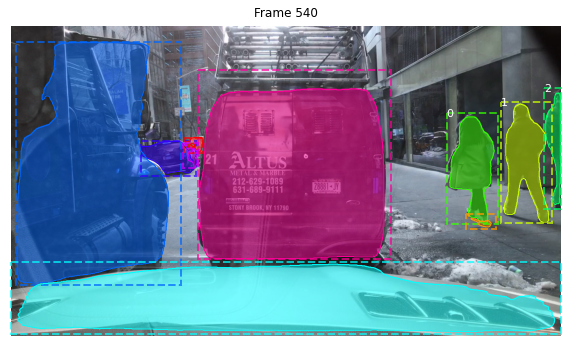

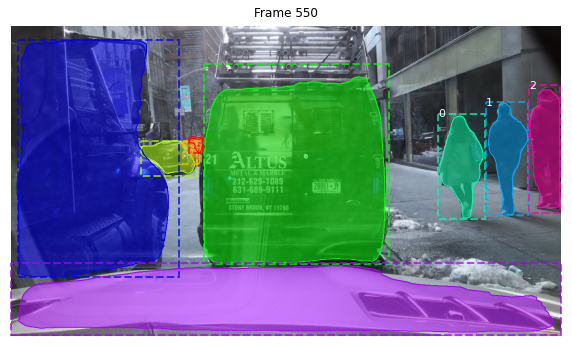

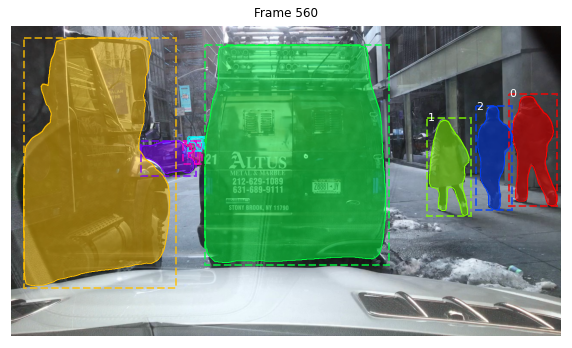

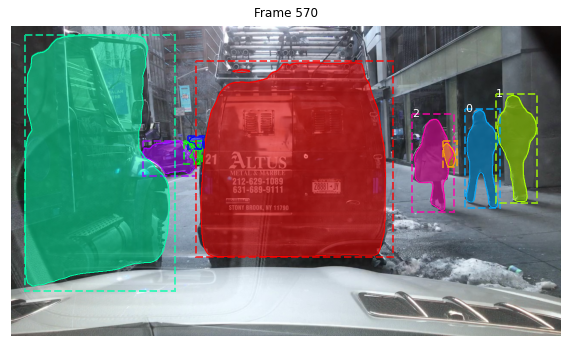

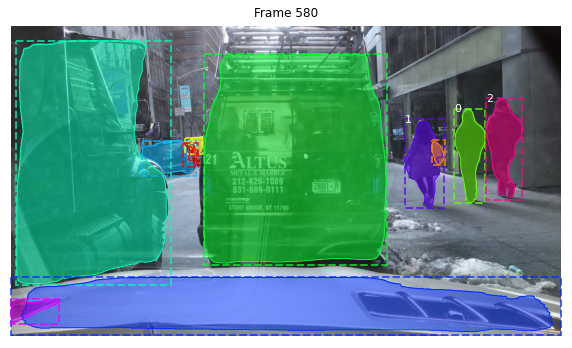

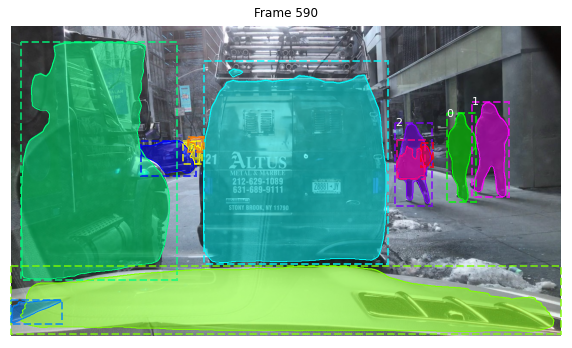

In [10]:
# Create paths to frames 
frame_path_1 = os.path.join(frames_dir,frames_list[540])
frame_path_2 = os.path.join(frames_dir,frames_list[550])
frame_path_3 = os.path.join(frames_dir,frames_list[560])
frame_path_4 = os.path.join(frames_dir,frames_list[570])
frame_path_5 = os.path.join(frames_dir,frames_list[580])
frame_path_6 = os.path.join(frames_dir,frames_list[590])

# Create frames directory
frame_paths = [frame_path_1, frame_path_2, frame_path_3, frame_path_4, frame_path_5, frame_path_6]

# Create frames dictionary to hold each frame and the pedestrians within it
frames_dict = dict()

# Frame counter 
frame_count = 0

# Begin loop through frames in frame directory
for frame_path in frame_paths:
    
    # Set plot details for visulisation
    _, ax = plt.subplots(1, figsize=(10, 10))
    
    # Open cv analyses frame data
    frame = cv2.imread(frame_path)
    
    # Run object detection
    results = model.detect([frame], verbose=0)
    
    # collect results
    r = results[0]
    
    # Collect labels for display
    labels =[]
    
    # Create object dictionary to hold objects detected within results
    objects_dict = dict()
    
    # Objects counter
    objects_count = 0
    
    # Pedestrian counter
    pedestrian_count = 0
    
    # Loop through all identified class id's 
    for id in r['class_ids']:
        
        # If class id is equal to 1 its a person
        if id == 1:
            
            # Instantiate Centroid Tracker class
            ct = CentroidTracker()
            
            # Add person plus person count to labels for visulisation
            labels.append(str(pedestrian_count))
            
            # create collection for coordiunates for centroid calculation
            rects = []
            
            # Set Coordinates of pedestrian for centroid calculation
            # x1 = top
            top = r['rois'][objects_count][1]
            # y1 = left
            left = r['rois'][objects_count][0]
            # x2 = width
            width = r['rois'][objects_count][3]
            # y2 = height
            height = r['rois'][objects_count][2]
            
            # Add coordinates to rects 
            rects.append([left, top, left + width, top + height])
            
            # Get centroid results for pedestrian returns: (id, array([ x, y])) id not working so ignore
            centroid = ct.update(rects)
            
            # Get centroid X and Y
            X = centroid[0][0]
            Y = centroid[0][1]
            
            # Add person object to objects dictionary with centroid coordinates
            objects_dict[objects_count] = {'pedestrian ' + str(pedestrian_count): (X, Y)}
            
            # Add 1 to pedestrian total count
            pedestrian_count += 1
        
        # Else conditional for all other objects detected
        else:
            # Adds empty string to labels
            labels.append("")
        
        # Add 1 to objects total count
        objects_count += 1
    
    # Concatonate the frame number from frame path 
    frame_number = frame_path.replace("/home/sam/Desktop/sam_bdd_videos/videos_for_frames/4/frames/", "").replace(".jpg", "")
    
    # Add frame with frame number to frames dictionary with the objects dictionary nested
    frames_dict[frame_count] = {'frame ' + frame_number : objects_dict}

    image_ir = visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'], ax=ax,
                                title="Frame " + str(frame_number), captions=labels)
    
    # Add 1 to frames total count
    frame_count += 1

# Loop through frames dictionary
for fd in frames_dict:
    # Print the frame data for each dictionary
    print(frames_dict[fd])


In [26]:
# Making dataset from the 3 pedestrians movments 

# Pedestrian 0
person_0_X = [767, 752, 746, 716, 717, 711]

person_0_Y = [1243, 1217, 1188, 1148, 1126, 1101]

# Pedestrian 1
person_1_X = [803, 776, 767, 759, 742, 741]

person_1_Y = [1368, 1324, 1295, 1266, 1235, 1217]

# Pedestrian 2
person_2_X = [782, 774, 789, 766, 760, 753]

person_2_Y = [1452, 1422, 1367, 1332, 1305, 1271]

In [27]:
# Import Memspectrum
from memspectrum import MESA

# Instantiate an Instance of MESA
m = MESA()

# Run Memspectrum on Person 0 X and Y
m.solve(person_0_X)

forecast = m.forecast(person_0_X, length = 1, number_of_simulations = 10, include_data = False)

print(forecast)

ValueError: could not broadcast input array from shape (6,) into shape (10,0)

### What should happen next

The above would be repeated for each persons X and Y coordinates giving a prediciton for there positoions 10 frames in future

The frame would be anaylsed by MRCNN

Bounding box centroid compared to memspectrum average 

Have picture with dot from guess and dot from bounding box 